In [361]:
# Loading neccesary packages:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

#
from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

#
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#
import warnings
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

#
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#
import pyodbc

#
import skimage


ModuleNotFoundError: No module named 'skimage'

In [340]:
# Connect to SQL and import dataset
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=Jaehyun\SQLEXPRESS;'
    r'DATABASE=EV_db;'
    r'Trusted_Connection=yes;'
)

train = pd.read_sql("SELECT * FROM ev.train_ev", conn)
test = pd.read_sql("SELECT * FROM ev.test_ev", conn)
test['Price']=np.nan
conn.close()

In [341]:
def style_table(df):
    """
    Applies a consistent styling to the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to style.

    Returns:
    pd.io.formats.style.Styler: The styled DataFrame.
    """
    color_header = 'royalblue'
    return df.style.set_table_styles(
        [{
            #HEADER:
            'selector': 'thead th',
            'props': [
                ('background-color', color_header),  # Color of background for header
                ('color', '#FFFFFF'),             # Color of text for header
                ('font-weight', 'normal'),
                ('text-align', 'center'),
                ('font-size', '0.85rem'),        # font-size of text for header
                ('border', '1px solid lightgray')  # Color of border for header
            ]
        }, {
            #CELLS:
            'selector': 'tbody td',
            'props': [
                ('background-color', '#F5F5F5'),  # Color of background for cells
                ('border', '1px solid #DCDCDC'),  # Color of border for cells
                ('font-weight', 'normal'),
                ('color', '#333333'),  # Color of text for readability
                ('font-size', '0.75rem'),        # font-size of text for header
            ]
        }]
    ).set_properties(**{'text-align': 'center'}).set_table_attributes('style="width:100%;"').hide(axis='index')

In [342]:
# 
style_table(train.head(5))

ID,Brand,Model,Car_Condition,Battery_Capacity,Driving_System,Driving_Distance,Warranty,Accident_History,Old,Price
TRAIN_0000,P,TayGTS,Nearly New,86.077003,AWD,13642,0,False,2,159.660004
TRAIN_0001,K,Niro,Nearly New,56.000000,FWD,10199,6,False,0,28.010000
TRAIN_0002,A,eT,Brand New,91.199997,AWD,2361,7,False,0,66.269997
TRAIN_0003,A,RSeTGT,Nearly New,nan,AWD,21683,3,False,0,99.160004
TRAIN_0004,B,i5,Pre-Owned,61.018002,AWD,178205,1,False,0,62.020000


In [343]:
#
style_table(test.head(5))

ID,Brand,Model,Car_Condition,Battery_Capacity,Driving_System,Driving_Distance,Warranty,Accident_History,Old,Price
TEST_000,P,TayCT,Nearly New,76.093002,AWD,14057,2,False,0,nan
TEST_001,B,iX,Brand New,90.000000,AWD,7547,8,False,0,nan
TEST_002,B,i5,Brand New,nan,RWD,7197,7,True,0,nan
TEST_003,H,ION5,Nearly New,68.478996,AWD,10357,7,False,1,nan
TEST_004,K,EV6,Brand New,nan,FWD,7597,10,False,0,nan


In [344]:
# Check duplicated values
print('The duplicate rows in the train dataset :', train.duplicated().sum() )
print('The duplicate rows in the test dataset :', test.duplicated().sum() )

The duplicate rows in the train dataset : 0
The duplicate rows in the test dataset : 0


In [345]:
def summary(df):
    """
    Creates a custom summary statistics table for a DataFrame.
    """
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum()
    summ['%missing'] = (df.isnull().sum() / len(df)) * 100
    summ['#unique'] = df.nunique()
    
    desc = df.describe(include='all').T

    # Add statistics if available
    for stat in ['min', 'max', 'mean', 'std']:
        if stat in desc.columns:
            summ[stat] = desc[stat].apply(lambda x: round(x, 2) if pd.api.types.is_number(x) else x)

    # Function to safely get values and round if numeric
    def safe_get_val(i):
        return df.iloc[i].apply(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

    summ['first value'] = safe_get_val(0)
    summ['second value'] = safe_get_val(1)
    summ['third value'] = safe_get_val(2)

    return summ


In [346]:
print(f'data shape: {train.shape}')

(
    summary(train)
    .reset_index()
    .rename(columns={'index': 'columns'})
    .pipe(style_table)
)

data shape: (7497, 11)


columns,data type,#missing,%missing,#unique,min,max,mean,std,first value,second value,third value
ID,object,0,0.000000,7497,nan,nan,nan,nan,TRAIN_0000,TRAIN_0001,TRAIN_0002
Brand,object,0,0.000000,7,nan,nan,nan,nan,P,K,A
Model,object,0,0.000000,21,nan,nan,nan,nan,TayGTS,Niro,eT
Car_Condition,object,0,0.000000,3,nan,nan,nan,nan,Nearly New,Nearly New,Brand New
Battery_Capacity,float64,2711,36.161131,194,46.000000,99.800000,69.400000,15.280000,86.080000,56.000000,91.200000
Driving_System,object,0,0.000000,3,nan,nan,nan,nan,AWD,FWD,AWD
Driving_Distance,int64,0,0.000000,6916,3.000000,199827.000000,44287.980000,55204.060000,13642,10199,2361
Warranty,int64,0,0.000000,11,0.000000,10.000000,4.960000,3.160000,0,6,7
Accident_History,bool,0,0.000000,2,nan,nan,nan,nan,False,False,False
Old,int64,0,0.000000,3,0.000000,2.000000,0.220000,0.570000,2,0,0


In [347]:
print(f'data shape: {test.shape}')

(
    summary(test)
    .reset_index()
    .rename(columns={'index': 'columns'})
    .pipe(style_table)
)

data shape: (846, 11)


columns,data type,#missing,%missing,#unique,min,max,mean,std,first value,second value,third value
ID,object,0,0.000000,846,nan,nan,nan,nan,TEST_000,TEST_001,TEST_002
Brand,object,0,0.000000,7,nan,nan,nan,nan,P,B,B
Model,object,0,0.000000,21,nan,nan,nan,nan,TayCT,iX,i5
Car_Condition,object,0,0.000000,3,nan,nan,nan,nan,Nearly New,Brand New,Brand New
Battery_Capacity,float64,304,35.933806,92,46.000000,99.800000,69.710000,15.080000,76.090000,90.000000,nan
Driving_System,object,0,0.000000,3,nan,nan,nan,nan,AWD,AWD,RWD
Driving_Distance,int64,0,0.000000,842,2.000000,199948.000000,44664.150000,55518.080000,14057,7547,7197
Warranty,int64,0,0.000000,11,0.000000,10.000000,5.030000,3.160000,2,8,7
Accident_History,bool,0,0.000000,2,nan,nan,nan,nan,False,False,True
Old,int64,0,0.000000,3,0.000000,2.000000,0.210000,0.540000,0,0,0


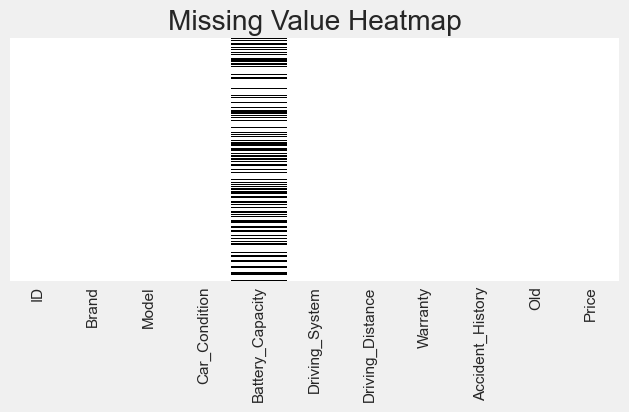

In [348]:
# show null data
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'binary')
plt.title('Missing Value Heatmap')
plt.show()

## EDA

### Numerical

In [349]:
def get_numerical_columns(df):
    return df.select_dtypes(include=['number']).columns.tolist()

def get_categorical_columns(df):
    return df.select_dtypes(include=['object','bool']).columns.tolist()

numerical_variables = get_numerical_columns(train)
categorical_variables = get_categorical_columns(train)

# Drop 'ID' if it's in the categorical list
categorical_variables = [col for col in categorical_variables if col.lower() != 'id']

target_variable = 'Price' 

categorical_variables

['Brand', 'Model', 'Car_Condition', 'Driving_System', 'Accident_History']

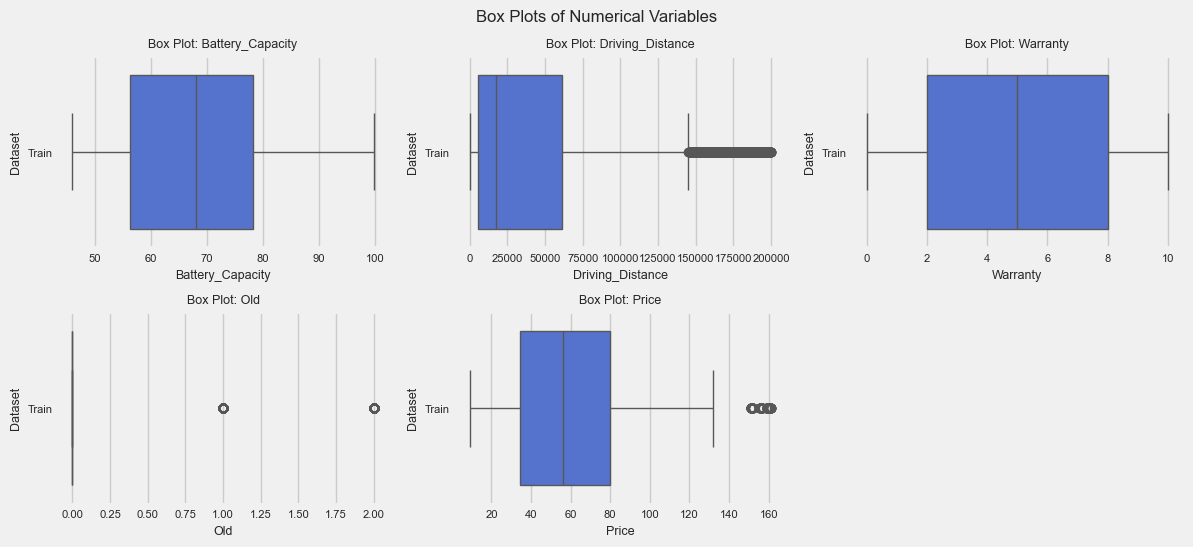

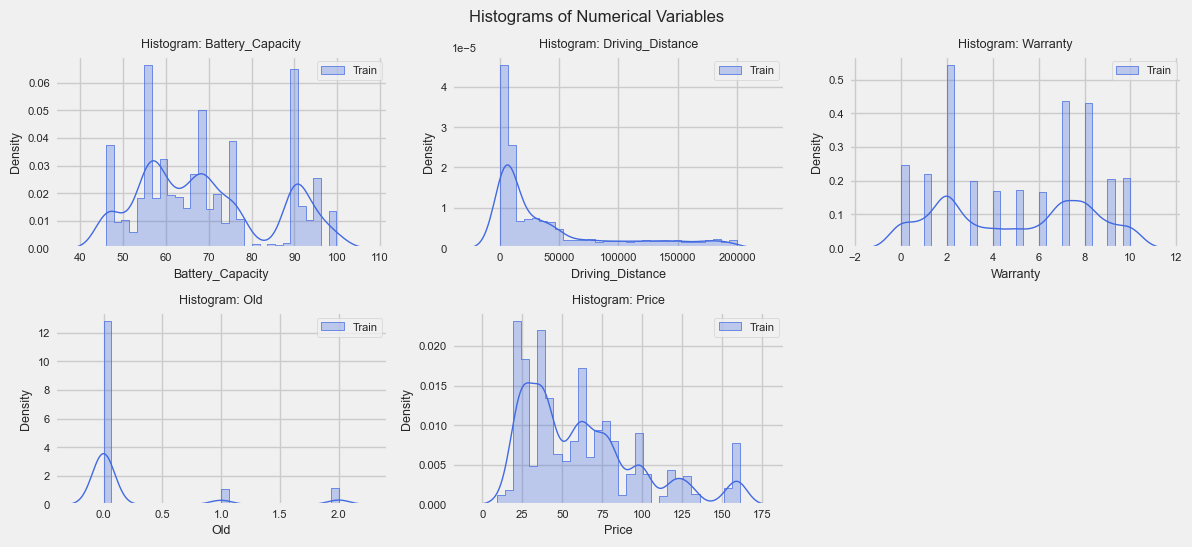

In [350]:
# Set global plot size
plt.rcParams['figure.figsize'] = (7, 3)  # width, height in inches

# Global font and plot settings
plt.rcParams['font.size'] = 9
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

# Custom color palette
custom_palette = ['royalblue']

# Add 'Dataset' column
train_temp = train.copy()
train_temp['Dataset'] = 'Train'

# Layout parameters
n_cols = 3
n_rows = 3
max_plots = n_cols * n_rows

# --- 1. BOX PLOTS ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axes = axes.flatten()

for i, variable in enumerate(numerical_variables):
    if i >= max_plots:
        break  # show only first 16 variables
    sns.boxplot(data=train_temp, x=variable, y='Dataset', palette=custom_palette, ax=axes[i])
    axes[i].set_title(f"Box Plot: {variable}")
    axes[i].set_xlabel(variable)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Box Plots of Numerical Variables", fontsize=12, y=1.02)
plt.show()

# --- 2. HISTOGRAMS ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axes = axes.flatten()

for i, variable in enumerate(numerical_variables):
    if i >= max_plots:
        break

    # Plot histogram without KDE
    sns.histplot(data=train_temp, x=variable, color=custom_palette[0], bins=30, stat='density', label='Train', ax=axes[i], element="step", fill=True, alpha=0.3)

    # Add KDE separately with control over line width
    sns.kdeplot(data=train_temp, x=variable, color=custom_palette[0], ax=axes[i], linewidth=1)

    axes[i].set_title(f"Histogram: {variable}")
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograms of Numerical Variables", fontsize=12, y=1.02)
plt.show()

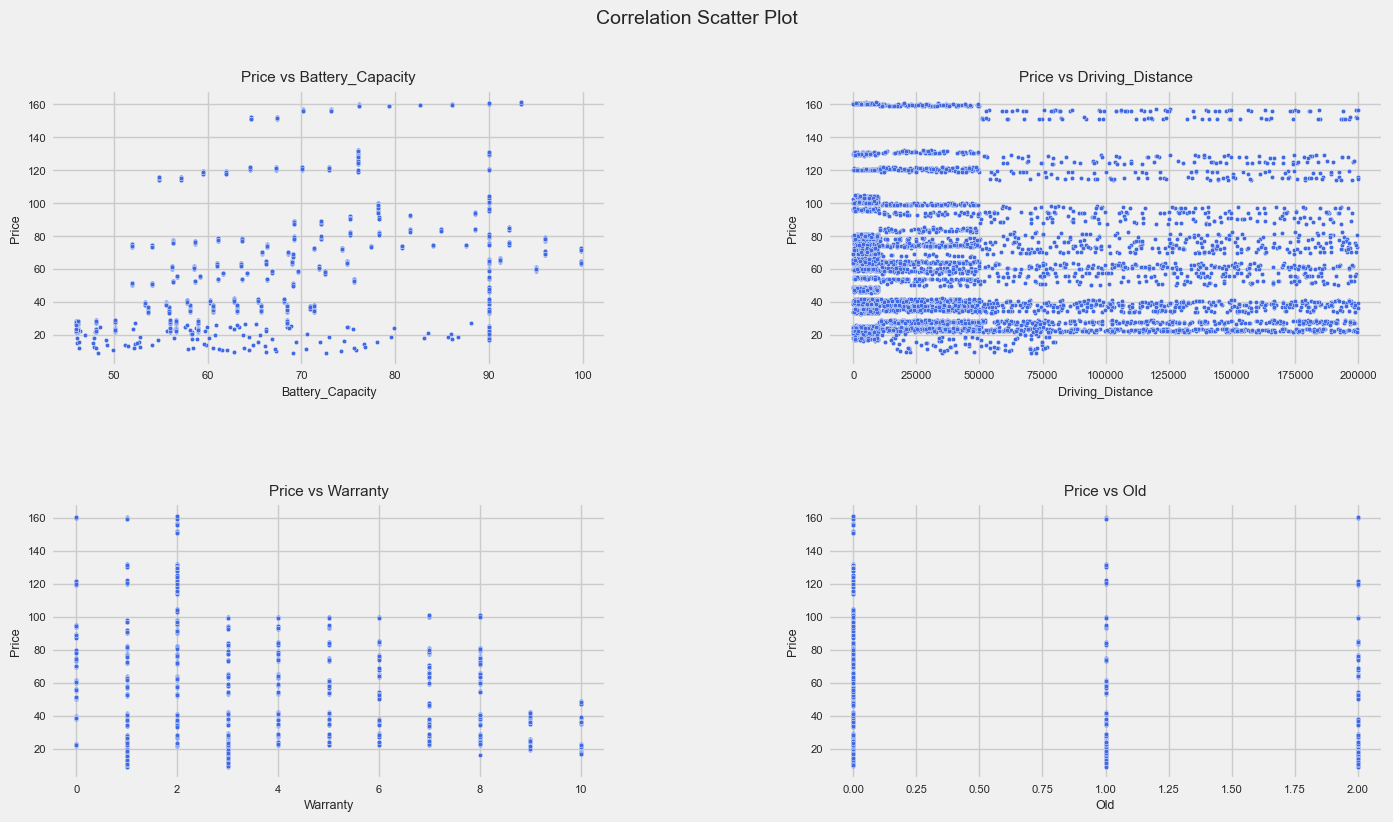

In [351]:
# Set global plot size
plt.rcParams['figure.figsize'] = (7, 3)  # width, height in inches

def plot_scatter_grid(df, x_vars, target, n_cols=2):
    '''Efficient scatterplot grid for numerical features vs target'''
    n_plots = len(x_vars)
    n_rows = math.ceil(n_plots / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
    axs = axs.flatten()

    for i, x_var in enumerate(x_vars):
        sns.scatterplot(
            x=df[x_var], 
            y=df[target], 
            color='royalblue', 
            s=10, 
            ax=axs[i]
        )
        axs[i].set_title(f'{target} vs {x_var}', fontsize=11)
        axs[i].set_xlabel(x_var, fontsize=9)
        axs[i].set_ylabel(target, fontsize=9)

    # Turn off unused axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Correlation Scatter Plot', fontsize=14, y=1.02)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()

# Plot the graph   
target = 'Price'
x_vars = [col for col in numerical_variables if col != target]
plot_scatter_grid(train, x_vars, target)

### Categorical

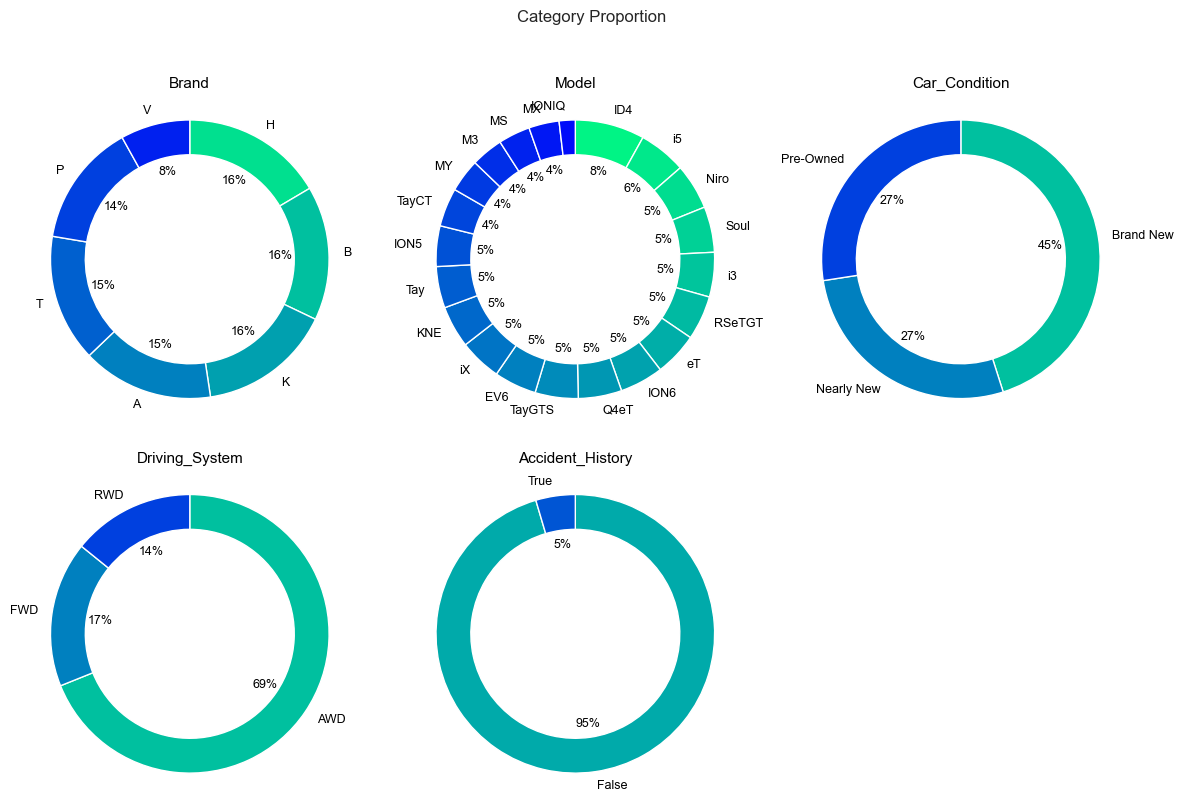

In [352]:
sns.set(style="whitegrid")

def Pie1(ax, NC, dd, other, title):
    if other:
        palette_color = list(reversed(sns.color_palette("winter", n_colors=NC).as_hex())) + ['#dddddd']
        d1 = dd.value_counts(normalize=True)
        d2 = d1[:NC].copy()
        d2['Other'] = 1 - d2.sum()
    else:
        palette_color = list(reversed(sns.color_palette("winter", n_colors=len(dd.unique())).as_hex()))
        d2 = dd.value_counts(normalize=True)

    def autopct_func(pct):
        return ('%1.0f%%' % pct) if pct > 3 else ''

    wedges, texts, autotexts = ax.pie(
        d2,
        autopct=autopct_func,
        textprops={'fontsize': 9, 'color': 'black'},
        wedgeprops=dict(width=0.25, edgecolor='white'),
        labels=d2.index.tolist(),
        pctdistance=0.65,
        labeldistance=1.1,
        colors=palette_color,
        startangle=90,
        counterclock=False
    )

    ax.set_title(title, color='black', fontsize=11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


# --- Prepare Categorical Columns ---
categorical_variables = [col for col in get_categorical_columns(train) if col.lower() != 'id']

# --- Grid Setup ---
n_cols = 3
n_plots = len(categorical_variables)
n_rows = (n_plots + n_cols - 1) // n_cols  # ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axs = axs.flatten()  # flatten in case of multiple rows

for i, col in enumerate(categorical_variables):
    NC, use_other = get_NCS(col)
    Pie1(axs[i], NC, train[col], use_other, title=col)

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

fig.suptitle('Category Proportion', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

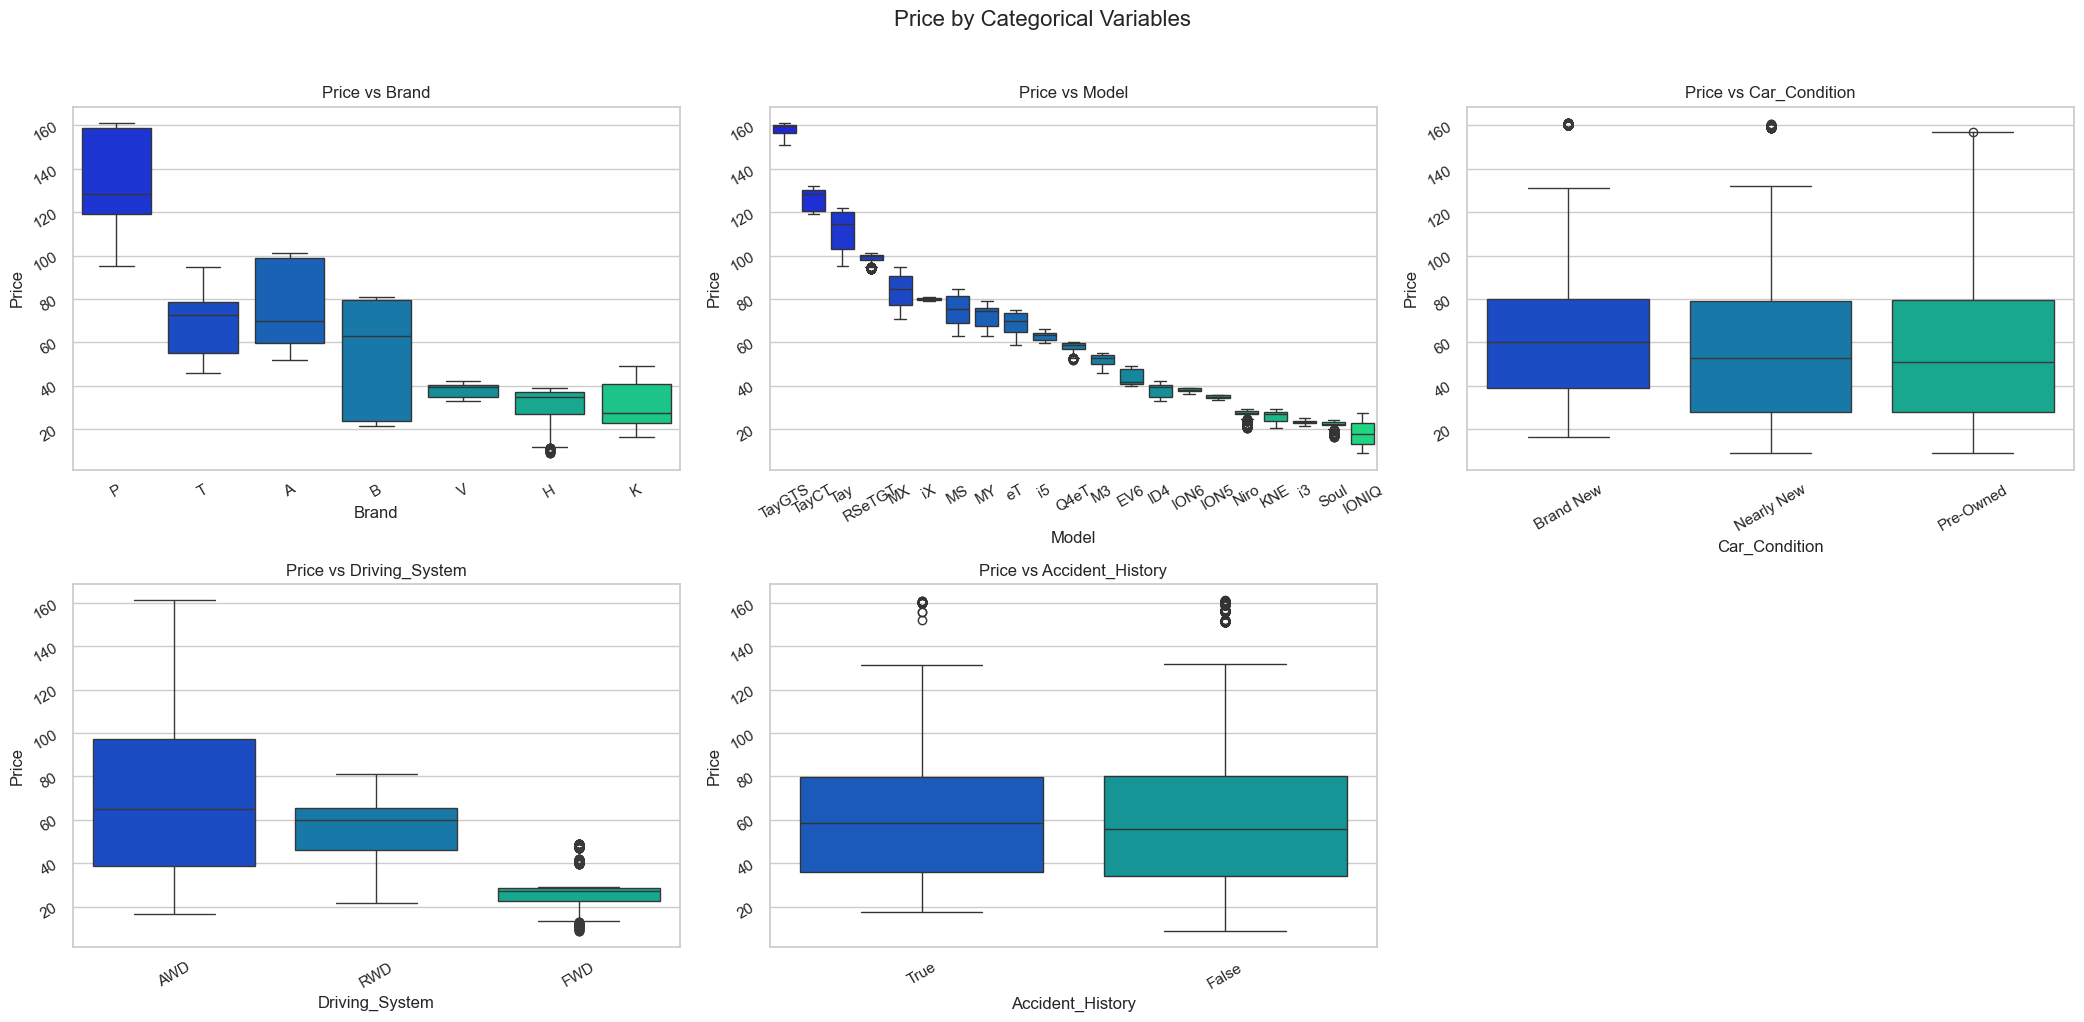

In [353]:
def srt_box(y, df, n_cols=3):
    '''Draw boxplots of categorical variables vs a target.'''
    
    num_vars = len(categorical_variables)
    n_rows = math.ceil(num_vars / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
    axs = axs.flatten()

    for idx, feature in enumerate(categorical_variables):
        ax = axs[idx]
        sorted_order = df.groupby(feature)[y].median().sort_values(ascending=False).index
        sns.boxplot(
            x=feature,
            y=y,
            data=df,
            palette='winter',
            order=sorted_order,
            ax=ax
        )
        ax.set_title(f'{y} vs {feature}')
        ax.tick_params(labelrotation=30)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    # Turn off unused subplots
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    # Add overall title
    fig.suptitle('Price by Categorical Variables', fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()
    
srt_box('Price', train_temp)

### Feature Engineering

#### Deal with Null Values

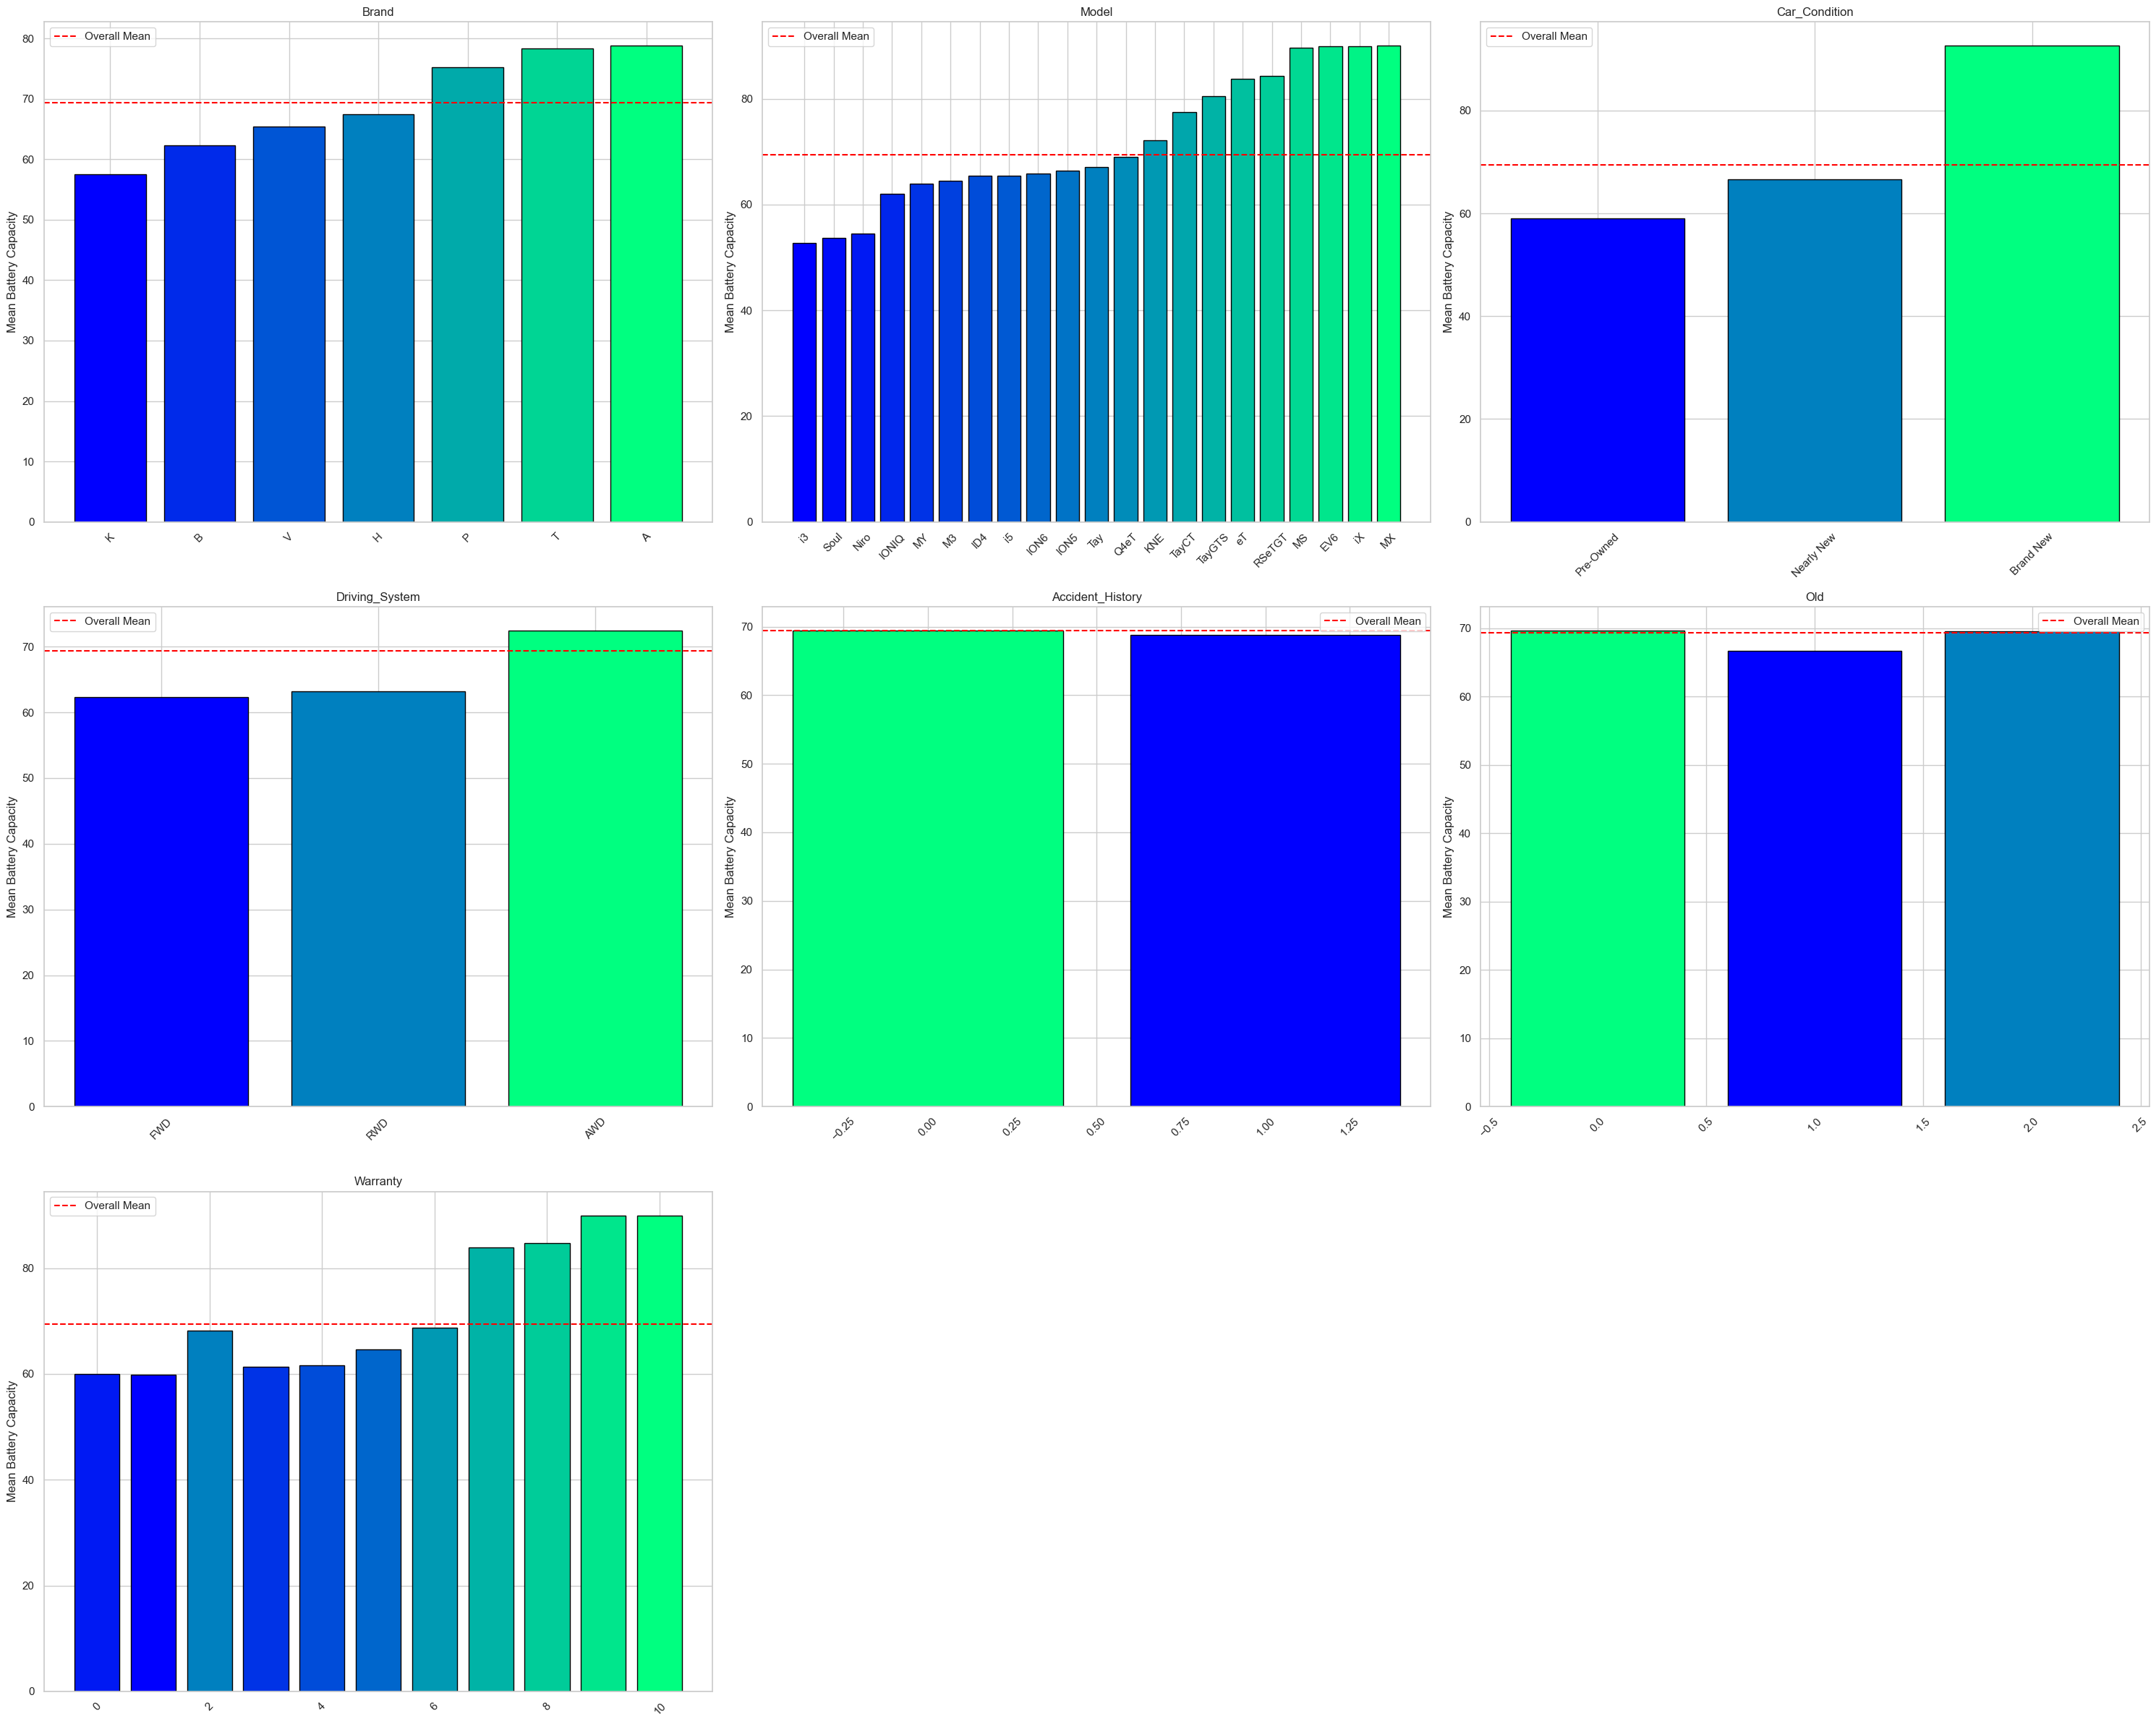

In [354]:
column_keys = ['Brand', 'Model', 'Car_Condition', 'Driving_System', 'Accident_History', 'Old', 'Warranty']

n_cols = 3
n_rows = (len(column_keys) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 8 * n_rows))
axes = axes.flatten()

overall_mean = train['Battery_Capacity'].mean()

for idx, col in enumerate(column_keys):
    ax = axes[idx]

    # Use groupby to get mean Battery_Capacity per category
    grouped = train.groupby(col)['Battery_Capacity'].mean().sort_values()

    colors = plt.cm.winter(np.linspace(0, 1, len(grouped)))
    bars = ax.bar(grouped.index, grouped.values, color=colors,edgecolor='black')

    ax.axhline(overall_mean, color='red', linestyle='--', label='Overall Mean')
    ax.set_title(col)
    ax.set_ylabel('Mean Battery Capacity')
    ax.legend()

    # Improve x-label readability
    ax.tick_params(axis='x', rotation=45)

# Turn off any unused axes
for i in range(len(column_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [355]:
# Calculate mean Battery Capacity for Warranty >= 7 and Warranty < 7 groups
mean_battery_warranty_7_or_more = train.loc[train['Warranty'] >= 7, 'Battery_Capacity'].mean()
mean_battery_warranty_less_7 = train.loc[train['Warranty'] < 7, 'Battery_Capacity'].mean()

# Replace missing Battery Capacity values temporarily with -1
train['Battery_Capacity'].fillna(-1, inplace=True)

# Fill missing Battery Capacity based on Warranty condition
train.loc[(train['Battery_Capacity'] == -1) & (train['Warranty'] >= 7), 'Battery_Capacity'] = mean_battery_warranty_7_or_more
train.loc[(train['Battery_Capacity'] == -1) & (train['Warranty'] < 7), 'Battery_Capacity'] = mean_battery_warranty_less_7

# Print the Result
(
    summary(train)
    .reset_index()
    .rename(columns={'index': 'columns'})
    .pipe(style_table)
)

columns,data type,#missing,%missing,#unique,min,max,mean,std,first value,second value,third value
ID,object,0,0.000000,7497,nan,nan,nan,nan,TRAIN_0000,TRAIN_0001,TRAIN_0002
Brand,object,0,0.000000,7,nan,nan,nan,nan,P,K,A
Model,object,0,0.000000,21,nan,nan,nan,nan,TayGTS,Niro,eT
Car_Condition,object,0,0.000000,3,nan,nan,nan,nan,Nearly New,Nearly New,Brand New
Battery_Capacity,float64,0,0.000000,196,46.000000,99.800000,73.050000,14.330000,86.080000,56.000000,91.200000
Driving_System,object,0,0.000000,3,nan,nan,nan,nan,AWD,FWD,AWD
Driving_Distance,int64,0,0.000000,6916,3.000000,199827.000000,44287.980000,55204.060000,13642,10199,2361
Warranty,int64,0,0.000000,11,0.000000,10.000000,4.960000,3.160000,0,6,7
Accident_History,bool,0,0.000000,2,nan,nan,nan,nan,False,False,False
Old,int64,0,0.000000,3,0.000000,2.000000,0.220000,0.570000,2,0,0


#### Check Correlation

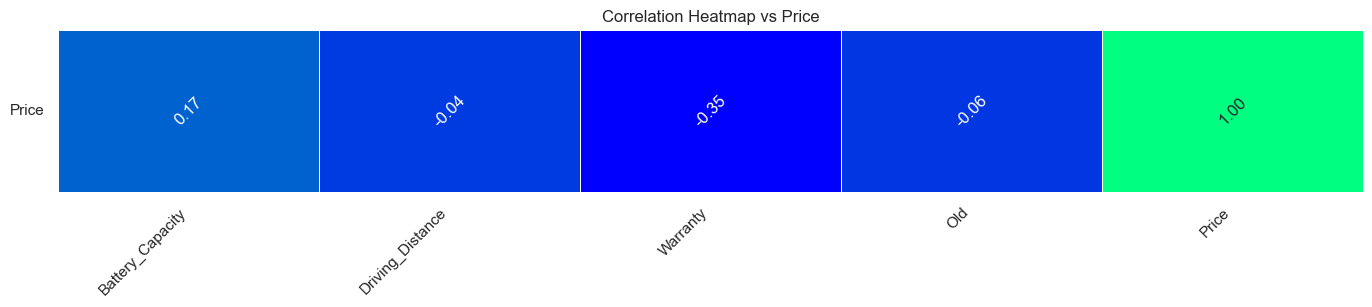

In [356]:
# Heatmap visualization without color bar, displaying values vertically
plt.figure(figsize=(15, 2))
ax = sns.heatmap(
    train[numerical_variables].corr()[[target_variable]].T,  # Transposing so features are on x-axis
    annot=True, 
    cmap='winter', 
    linewidths=0.5, 
    cbar=False, 
    fmt=".2f", 
    annot_kws={"rotation": 45}  # Rotate annotations to be vertical
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title('Correlation Heatmap vs Price')
plt.show()

#### Check Distribution

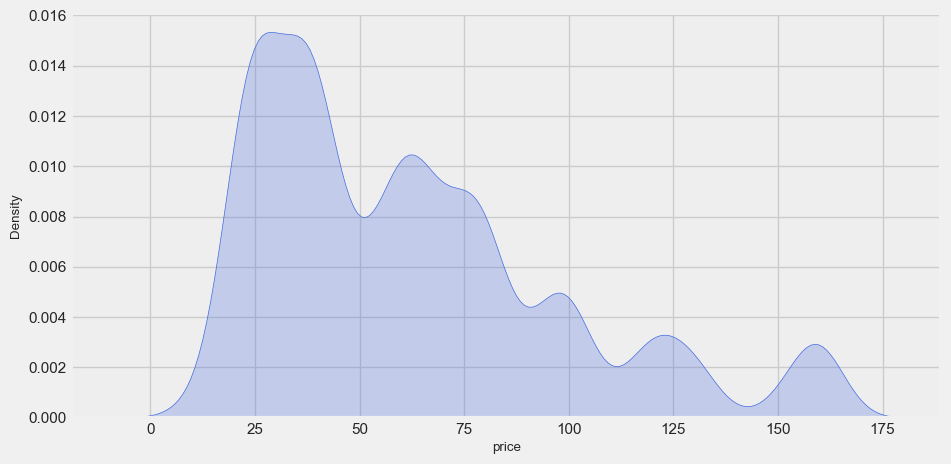

In [375]:
fig, axs  = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.kdeplot(data=train, x='Price', color='royalblue', fill=True, log_scale=False)
ax.set(xlabel='price')
plt.show()

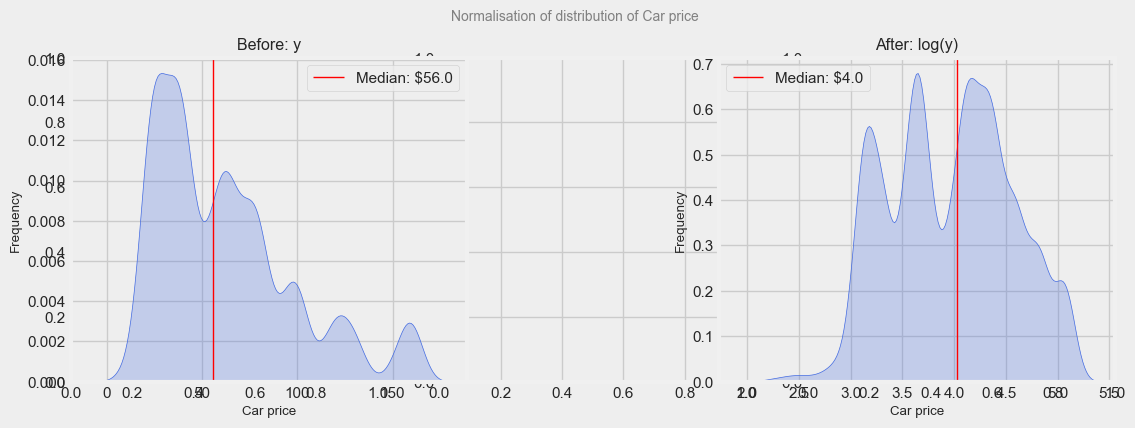

In [ ]:
'''
upTitleSize=10

def hist_one(d, b, col, transf):
    color1= '#ddddff'
    #plt.hist(d, bins=b, color='skyblue', edgecolor='white', density = True)
    sns.kdeplot(d, color='royalblue', fill=True, log_scale=False)
    #sns.histplot(d, kde=True, color='skyblue', bins=40, alpha=0.7, line_kws={'linewidth': 2, 'color': 'black'}, edgecolor='white')
    
    # Adding mean and median lines
    #mean_price = d.mean()
    median_price = d.median()
    #plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_price:.2f}')
    plt.axvline(median_price, color='red', linestyle='-', linewidth=1, label=f'Median: ${median_price:.1f}')
    
    plt.title(transf)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.rcParams['font.size'] = 8
    fig.patch.set_linewidth(1)
    #fig.patch.set_edgecolor('black')  
    plt.rcParams['axes.facecolor'] = '#eeeeee'
    plt.legend()

def hist1(t1, t2, col, transf):
    fig, axs  = plt.subplots(1, 3, figsize=(12, 4))
    #plt.title(f'{title}', color='gray', fontsize=20)
    plt.suptitle(f'Normalisation of distribution of {col}', fontsize=SupTitleSize, y=1,  color='gray')

    plt.subplot(1, 5, (1,2))
    hist_one(t1, 100, col, transf='Before: y')

    plt.subplot(1, 5, 3)
    plt.axis('off')

    plt.subplot(1, 5, (4,5))
    hist_one(t2, 30, col, f'After: {transf}(y)')
    
    fig.patch.set_facecolor('#eeeeee')
    plt.show()
    
t1 = train.Price
#t2 = np.power(train.price, 1/15) 
t2 = np.log(train.Price) 
hist1(t1, t2, 'Car price', 'log')
'''

In [ ]:
train['']

0       159.66
1        28.01
2        66.27
3        99.16
4        62.02
         ...  
7492     35.95
7493     23.40
7494    120.00
7495     24.00
7496     74.06
Name: Price, Length: 7497, dtype: float64